In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch

We will add a critic to the loss function now. Instead of just weight the probability of the action with the value of making that action from that state, we will weight it the that compared to how good it is to be in that state. 
So the weight will be the value of making that action compared to how good it is to be in that state in general. This is an advantage function. </br></br>
To find the value of being in a state, we will predict it as a separate output from our parametrised policy neural network. That prediction will be used in a TD(1) calculation, in which we will minimise the difference between estimation of the next step value as the sum of immidiate reward and discounted value of the next step and just the value of the next step. By minimising this difference through gradient descent we will iteratively improve the prediction quality for the state value. </br></br>
In the second part of this notebook we will explore TD(lambda) evaluations instead of just TD(1).

In order to make the TD(1) state value assessment, we need to collect (state, action, reward, next_state) for each interaction. Let's do that. To develop and test the code base will operate with the same environments as before:
1) 'Pendulum-v1'
2) 'MountainCarContinuous-v0'

In [2]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)

init_observation = env.reset()
state_len = len(env.reset())
action_len = len(env.action_space.sample())

Let's create a dummy agent for now to fill out the functionality later

In [58]:
class a2c_agent(torch.nn.Module):
    def __init__(self, action_len):
        super().__init__()
        self.action_len = action_len
        
        
    def forward(self):
        pass
    
    
    def act(self, state):
        action = [1]*self.action_len
        state_val = 3
        return action, state_val

In [59]:
agent = a2c_agent(action_len)

In [60]:
agent.act(init_observation)

([1], 3)

In [5]:
def play_single_game(env, model, n_steps=150, render=False):
    """
    outputs (rewards, logits, state_values, dones)
    """
    observation = env.reset()

    rewards, logits, state_values, dones = [], [], [], []
    for _ in range(n_steps):
        if render:
            env.render()
        
        (action, logit, state_value) = model.act(torch.tensor(observation, dtype=torch.float32))
        
        observation, reward, done, info = env.step(action)
            
        rewards.append(reward)
        logits.append(logit)
        state_values.append(state_value)
        dones.append(done)
        
        if done:
            break
    env.close()
    
    return rewards, logits, state_values, dones

In [71]:
one_step_data = play_single_game(env, agent, render = False)[0]

In [79]:
(state, action, reward, next_state, done, current_state_val, next_state_val) = one_step_data

In [80]:
discount = .97

In [85]:
# calculation of TD value
lookahead_val_of_current_state = reward + discount * next_state_val

tens_current_state_val = torch.tensor(current_state_val, dtype=torch.float32)
tens_lookahead_val_of_current_state = torch.tensor(lookahead_val_of_current_state, dtype=torch.float32)

TD_val = torch.nn.functional.mse_loss(tens_current_state_val, 
                                      tens_lookahead_val_of_current_state)
TD_val

tensor(5.2632)

We will minimise the TV_val and this way improve the value estimation by our neural network. So TD_val is in essence a loss function for our critic.

The advantage function will be the difference between the sum discounted rewards from the current state and action onwards and the current state value as per the prediction of our neural network.

As before, for the first code version we will play out a full trajectory save all the data needed and only then calculate the loss.

We will now fill out the agent functionality

In [16]:
# We are making 3 output heads heads here, for mu, sigma and state value
    
class a2c_agent(torch.nn.Module):
    """
    REINFORCE RL agent class. Returns action when the ParameterisedPolicy.act(observation) is used.
    observation is a gym state vector.
    obs_len - length of the state vector
    act_space_len - length of the action vector
    
    """
    def __init__(self, obs_len=state_len, act_space_len=action_len):
        super().__init__()
        self.obs_len = obs_len
        self.act_space_len = act_space_len
        
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
        
#         self.lin_2 = torch.nn.Linear(256, 64)
#         self.rel_2 = torch.nn.ReLU()
            
        self.lin_3 = torch.nn.Linear(256, self.act_space_len)
        
        self.lin_4 = torch.nn.Linear(256, self.act_space_len)
        self.elu = torch.nn.ELU()
        
        self.lin_5 = torch.nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
#         x = self.lin_2(x)
#         x = self.rel_2(x)
        
        mu = self.lin_3(x)
        
#         x = self.lin_4(x)
        sigma = self.elu(self.lin_4(x)) + 1.000001
        
        state_value = self.lin_5(x)
#         state_value = 1
        return mu, sigma, state_value
    
    def act(self, observation):
        
        (mus, sigmas, state_value) = self.forward(torch.tensor(observation, dtype=torch.float32))
        m = torch.distributions.normal.Normal(mus, sigmas)
        tens_action = m.sample()
        logit = m.log_prob(tens_action)
        action = tens_action.detach().numpy()
        return action, logit, state_value

In [9]:
DISCOUNT=0.9

In [109]:
agent = a2c_agent()

In [110]:
agent.act(init_observation)

(array([-0.19774912], dtype=float32),
 tensor([-0.9402], grad_fn=<SubBackward0>))

Now that the agent is drafted, we can write the learning loop.
- Play out the trajectory, collecting each step data for the value function and 
    rewards and logits for the action value estimation
- Once the trajectory data is collected, we will calculate actor loss almost as previously, by finding mean discounted reward across all steps of the trajectory. The only difference is that instead of just an immidiate reward we will use an advantage function -- difference between immidiate reward and value of the preset step. The critic loss will be an mse between two vectors instead of scalars as was calculated above. Each vector component will be the predicted value and calculated value of the current step as in the calculation above.

We will no write one pass of the learning loop

In [70]:
t = np.array([1,2,3])

In [71]:
np.append(t, 0)

array([1, 2, 3, 0])

In [78]:
get_next_state_values([1,2,3])

array([2, 3, 0])

In [82]:
torch.zeros(1)

tensor([0.])

In [83]:
torch.tensor([1,1,2])

tensor([1, 1, 2])

In [84]:
torch.cat([torch.tensor([1,1,2]), torch.zeros(1)])

tensor([1., 1., 2., 0.])

In [17]:
def get_next_state_values(current_state_values):
    current_state_values = torch.cat([current_state_values, torch.zeros(1)])
    return current_state_values[1:]

def calc_cum_rewards(rewards, discount=DISCOUNT):
    new_rews = [0]
    for el in rewards[::-1]:
        val = el + discount * new_rews[-1]
        new_rews.append(val)
    return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)

def calc_actor_loss(rewards, logits, current_state_vals):
    cum_rewards = calc_cum_rewards(rewards, discount=DISCOUNT)
    logits = torch.stack(logits).flatten()
    current_state_vals = torch.stack(current_state_vals).flatten()
    
    # we are detaching the advantage b/c we don't need to backprop (adjust nn parameters) in it, 
    # only adjusting parameters through logits for this loss. 
    # We will adjust nn parameters for state value prediction in the critic loss
    advantage = (cum_rewards - current_state_vals).detach()
    
#     entropy = -torch.sum(logits.exp()*logits, dim=-1)
    
    loss = -(logits * advantage).mean()# - 0.001 * entropy
    
    return loss


def calc_critic_loss(state_vals, rewards, discount, dones):
    
    
    tens_dones = torch.tensor(dones)
    stacked_current_state_val = torch.stack(state_vals).flatten()
    stacked_next_state_vals = get_next_state_values(stacked_current_state_val)
    
#     stacked_next_state_val = torch.stack(next_state_vals).flatten()
    
    tens_rewards = torch.tensor(rewards, dtype=torch.float32)
    
    # multiplication by inverted dones is done here to avoid adding the value of the
    # next state in case current state was terminal
    tens_lookahead_val_of_current_state = tens_rewards + discount * (stacked_next_state_vals * ~tens_dones)
    
    td_val = torch.nn.functional.mse_loss(stacked_current_state_val, 
                                               tens_lookahead_val_of_current_state)
    
    # let's add L2 regularisation to prevent from weights explosion
#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum() for p in agent.parameters())
 
#     critic_loss = td_val# + l2_lambda * l2_norm
    
    return td_val

In [91]:
#collecting the trajectory data
state_vals, rewards, logits, next_state_vals, dones = play_single_game(env, agent, steps_n=100, render = True)

#calculating sum discounted rewards from current state till the end of trajectory
cum_rewards = calc_cum_rewards(rewards, .9)

#calculating actor loss
act_loss = calc_actor_loss(cum_reards, logits, state_vals)

#calculating critic loss
critic_loss = calc_critic_loss(state_vals, rewards, next_state_vals, .9, dones)

total_loss = act_loss+critic_loss

NameError: name 'cum_reards' is not defined

In [350]:
total_loss.backward()

Total loss backprops successfully, so we can now write a learning loop and see if loss decreases over time and rewards

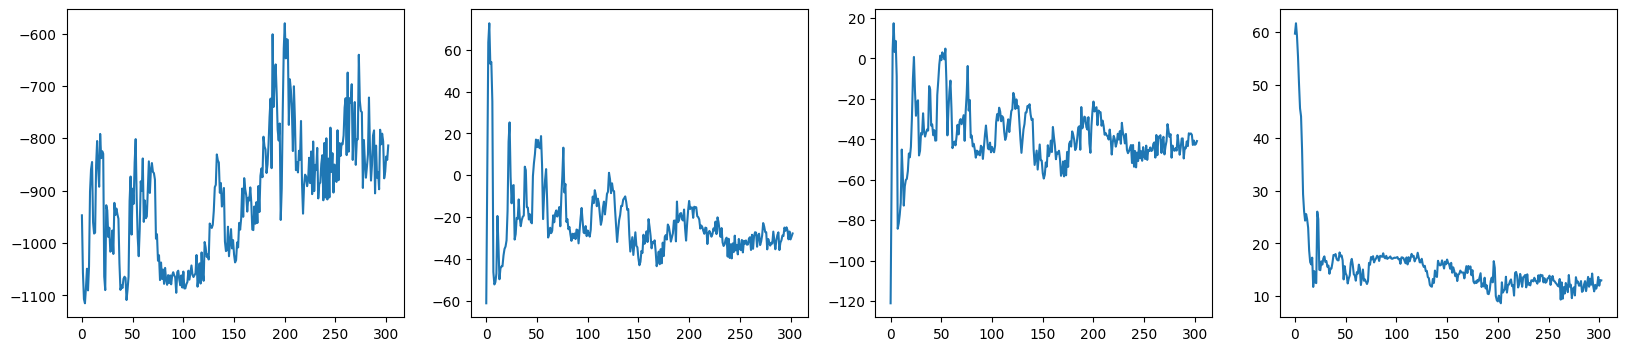

KeyboardInterrupt: 

In [19]:
env = gym.make(env_name)
agent = a2c_agent()

opt = torch.optim.Adam(agent.parameters(), lr=0.0008)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4000, gamma=0.6)

all_rewards, mean_rewards, all_losses, mean_losses, \
    all_act_losses, mean_act_losses, all_critic_losses, mean_critic_losses = [], [], [], [], [], [], [], []

for _ in range(int(1e5)):

    rewards, logits, current_state_values, dones = play_single_game(env, agent, n_steps=150, render=False)
    
    sum_game_rewards = sum(rewards)
    
    act_loss = calc_actor_loss(rewards, logits, current_state_values)
    critic_loss = calc_critic_loss(current_state_values, rewards, DISCOUNT, dones)
    total_loss = (act_loss + critic_loss)
    
    opt.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), 50)
    opt.step()
    lr_scheduler.step()
    
    all_losses.append(total_loss.detach().numpy())
    all_act_losses.append(act_loss.detach().numpy())
    all_critic_losses.append(critic_loss.detach().numpy())
    
    all_rewards.append(sum_game_rewards)
    
    ave_over = 50
    if _%ave_over == 0:
        clear_output()
        
        mean_rewards.append(np.mean(all_rewards[-ave_over:]))
        mean_losses.append(np.mean(all_losses[-ave_over:]))
        mean_act_losses.append(np.mean(all_act_losses[-ave_over:]))
        mean_critic_losses.append(np.mean(all_critic_losses[-ave_over:]))
        
        fig, ax = plt.subplots(1, 4, figsize = [20, 4])
        
        ax[0].plot(mean_rewards)
        ax[1].plot(mean_losses)
        ax[2].plot(mean_act_losses)
        ax[3].plot(mean_critic_losses)
        
        plt.show()

The agent learns an ok policy, let's now try a few other things.

For example, let's try having 2 separate models for actor and critic and update critic on every step, while updating actor only after trajectory ends.

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

In [2]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)

init_observation = env.reset()
state_len = len(env.reset())
action_len = len(env.action_space.sample())

DISCOUNT=.9

In [3]:
class Actor(torch.nn.Module):
    
    def __init__(self, obs_len=state_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
            
        self.lin_2 = torch.nn.Linear(256, 1)
        
        self.lin_3 = torch.nn.Linear(256, 1)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
        mu = self.lin_2(x)
        
        x = self.lin_3(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma
    
    def act(self, observation):
        (mu, sigma) = self.forward(torch.tensor(observation, dtype=torch.float32))
        m = torch.distributions.normal.Normal(mu, sigma)
#         action = torch.clamp(m.sample(), -3, 3)
        action = m.sample()
        logit = m.log_prob(action)   
        
        return action, logit
    
# Critic here is extremely simple to avoid overfitting to trajectory, since we do not have batches yet here
class Critic(torch.nn.Module):
    
    def __init__(self, obs_len=state_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, self.obs_len)
        self.drop = torch.nn.Dropout(p=0.6)
        self.lin_2 = torch.nn.Linear(self.obs_len, 1)
    
    def forward(self, x):
        x = self.lin_1(x)
        x = self.drop(x)
        x = self.lin_2(x)
        return x

# This is an experimental critic, essentialy one baseline value for all states, it has no input 
# and it returns it's own weight
class CriticStateless(torch.nn.Module):
        
    def __init__(self):
        super().__init__()
        self.lin_1 = torch.nn.Linear(1, 1, bias=False)

    def forward(self):
        x = self.lin_1(torch.tensor([1.], dtype=torch.float32))
        return x

In [11]:
tmp = CriticStateless()

In [12]:
tmp()

tensor([-0.7714], grad_fn=<SqueezeBackward3>)

In [13]:
for i in tmp.parameters():
    print(i)

Parameter containing:
tensor([[-0.7714]], requires_grad=True)


In [6]:
def create_cum_rewards(rewards, discount=DISCOUNT):
    new_rews = [0]
    for el in rewards[::-1]:
        val = el + discount * new_rews[-1]
        new_rews.append(val)
    return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)


def play_game(env, actor, critic, critic_opt, n_steps=300, render=False, stateless=False):
    state = env.reset()

    rewards, logits, state_vals, critic_losses = [], [], [], []
    for _ in range(n_steps):
        if render:
            env.render()
        
        action, logit = actor.act(torch.tensor(state, dtype=torch.float32))
        next_state, reward, done, info = env.step([action.detach().numpy()[0]])

        rewards.append(reward)
        logits.append(logit)
        if stateless:
            state_val, next_state_val = critic(), critic()
        else:
            state_val = critic(torch.tensor(state, dtype=torch.float32)) 
            next_state_val = critic(torch.tensor(next_state, dtype=torch.float32))
            
        critic_loss = calc_critic_loss(reward, state_val, next_state_val)
        critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic.parameters(), 50)
        critic_opt.step()
        
        critic_losses.append(critic_loss)
        state_vals.append(state_val)
        
        state = next_state
        if done:
            break
    env.close()
    
    return rewards, logits, state_vals, critic_losses

def calc_actor_loss(rewards, logits, current_state_val):
    cum_rewards = create_cum_rewards(rewards, discount=DISCOUNT)
    stacked_logits = torch.stack(logits).flatten()
    
    current_state_val = torch.stack(current_state_val).flatten()
    advantage = (cum_rewards - current_state_val).detach() # 
    print('Med advantage:', advantage.median().detach().numpy())
    print('Med Q(s,a):', cum_rewards.median().detach().numpy())
    print('Med V(s):', current_state_val.median().detach().numpy())
    print('='*30)
    
    loss = -(stacked_logits * advantage).mean()
    
    return loss

def calc_critic_loss(reward, current_state_val, next_state_val, gamma=DISCOUNT):
    reward = torch.tensor(reward, dtype=torch.float32)
    lookahead = reward + gamma * next_state_val
    return torch.nn.functional.mse_loss(current_state_val, lookahead)

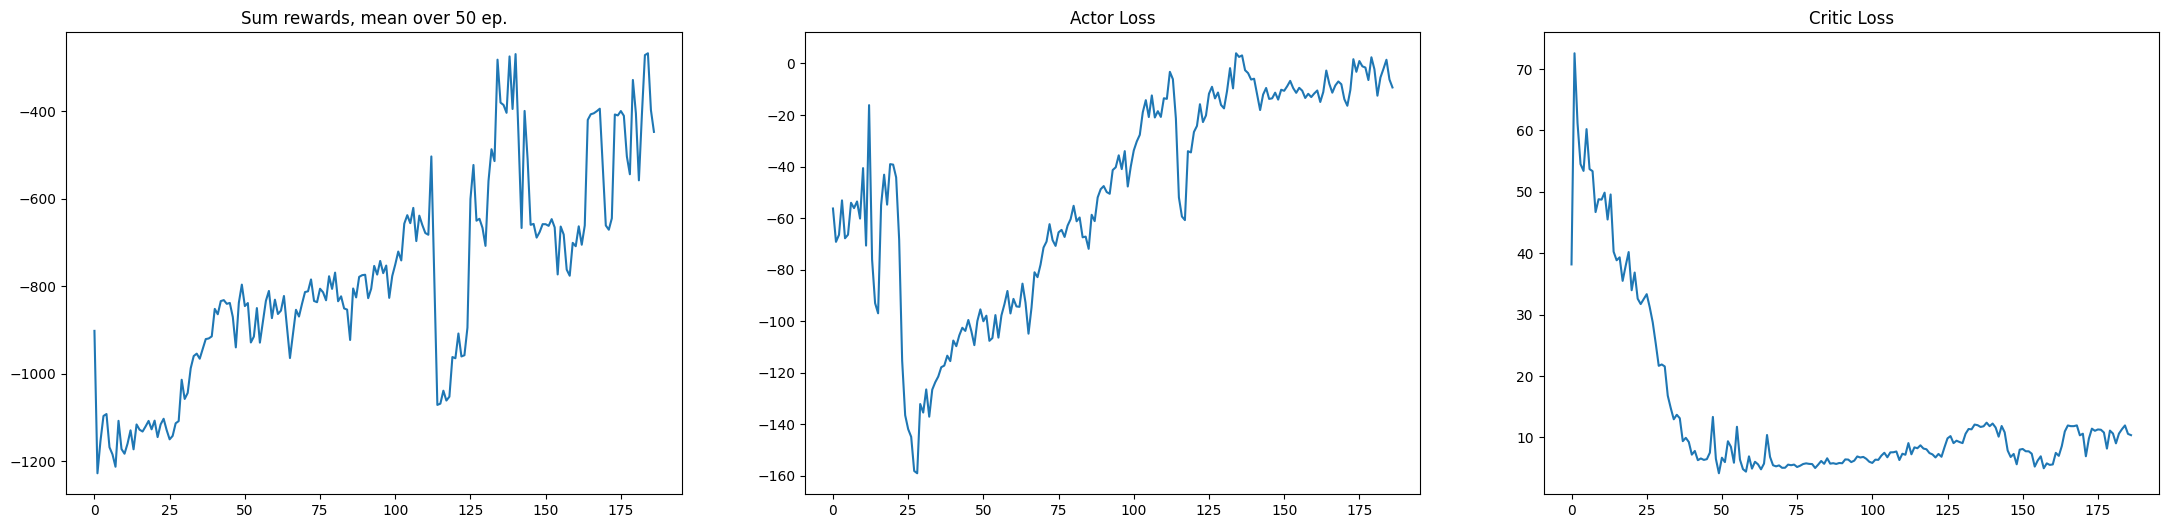

Med advantage: 9.374332
Med Q(s,a): -27.822891
Med V(s): -37.19669
Med advantage: 28.607697
Med Q(s,a): -8.221412
Med V(s): -36.82582
Med advantage: 9.56645
Med Q(s,a): -27.778673
Med V(s): -37.184902
Med advantage: 26.301088
Med Q(s,a): -10.519743
Med V(s): -37.006752
Med advantage: 25.570082
Med Q(s,a): -10.839621
Med V(s): -36.8547
Med advantage: 3.4000092
Med Q(s,a): -33.488136
Med V(s): -37.178467
Med advantage: 18.116028
Med Q(s,a): -18.259706
Med V(s): -36.98332
Med advantage: -32.553173
Med Q(s,a): -70.10189
Med V(s): -37.714508
Med advantage: -28.721115
Med Q(s,a): -66.16617
Med V(s): -37.658764
Med advantage: 21.410784
Med Q(s,a): -15.781111
Med V(s): -37.127228
Med advantage: 9.966534
Med Q(s,a): -27.270996
Med V(s): -37.18676
Med advantage: -18.39272
Med Q(s,a): -55.791965
Med V(s): -37.42977
Med advantage: -18.55717
Med Q(s,a): -55.751717
Med V(s): -37.398464
Med advantage: 25.117203
Med Q(s,a): -12.078888
Med V(s): -37.193287
Med advantage: 26.395834
Med Q(s,a): -10.32277

KeyboardInterrupt: 

In [7]:
model = Actor()
critic_model = Critic()  #CriticStateless() # #

opt = torch.optim.Adam(model.parameters(), lr=0.0004)
critic_opt = torch.optim.Adam(critic_model.parameters(), lr=0.00007)

lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3500, gamma=0.8)

rews, mean_rews, losses, mean_losses, critic_losses, mean_critic_losses = [], [], [], [], [], []
for _ in range(int(1e5)):
    rewards, logits, current_state_vals, game_critic_losses =\
        play_game(env, model, critic_model, critic_opt, n_steps=150, render=False, stateless=False)
    
    loss = calc_actor_loss(rewards, logits, current_state_vals)
    critic_losses.append(torch.stack(game_critic_losses).median().detach().numpy())
    
    losses.append(loss.detach().numpy())
    rews.append(np.sum(rewards))

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 60)
    opt.step()
    lr_scheduler.step()
    
    ave_over = 50
    if _%ave_over==0:
        clear_output()
        mean_rews.append(np.median(rews[-ave_over:]))
        mean_losses.append(np.median(losses[-ave_over:]))
        mean_critic_losses.append(np.median(critic_losses[-ave_over:]))
        
        fig, ax = plt.subplots(1, 3, figsize=[27, 6])
        ax[0].plot(mean_rews); ax[0].set_title('Sum rewards, mean over 50 ep.')
        ax[1].plot(mean_losses); ax[1].set_title('Actor Loss')
        ax[2].plot(mean_critic_losses); ax[2].set_title('Critic Loss')
        plt.show()
        
    

In [190]:
t = play_game(env, model, critic_model, critic_opt, n_steps=500, render=True)

/var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/ipykernel_75489/3020450649.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (mu, sigma) = self.forward(torch.tensor(observation, dtype=torch.float32))


In [173]:
sum(t[0])

-132.873395770807

The agent learns a pretty good policy, but the critic is extremely keen to overfit the trajectory. 
To avoid that, let's introduce batches.

The critic overfits to one trajectory. Hence we need to fit it to TD values from different trajectories. 
But at the same time we don't want to wait for the trajectory to end to update critic. Hence, we can maintain several agents that play simultaneously. Each step data is combined into vectors that are used to calculate loss in vector form.

In [8]:
class Actor(torch.nn.Module):
    
    def __init__(self, obs_len=state_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, 256)
        self.rel_1 = torch.nn.ReLU()
            
        self.lin_2 = torch.nn.Linear(256, 1)
        
        self.lin_3 = torch.nn.Linear(256, 1)
        self.elu = torch.nn.ELU()
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.rel_1(x)
        
        mu = self.lin_2(x)
        
        x = self.lin_3(x)
        sigma = self.elu(x) + 1.000001
        
        return mu, sigma
    
    def act(self, observation):
        (mu, sigma) = self.forward(torch.tensor(observation, dtype=torch.float32))
        m = torch.distributions.normal.Normal(mu, sigma)
        action = m.sample()
#         action = torch.clamp(action, -30, 30)
        logit = m.log_prob(action)   
        
        return action, logit
    

class Critic(torch.nn.Module):
    
    def __init__(self, obs_len=state_len):
        super().__init__()
        self.obs_len = obs_len
        self.lin_1 = torch.nn.Linear(self.obs_len, self.obs_len)
        self.drop = torch.nn.Dropout(p=0.6)
        self.lin_2 = torch.nn.Linear(self.obs_len, 1)
    
    def forward(self, x):
        x = self.lin_1(x)
        x = self.drop(x)
        x = self.lin_2(x)
        return x

In [11]:
class batch_agent():    
    def __init__(self, actor, critic, env_name=env_name, n_envs=32, gamma=.9):
        self.env_name = env_name
        self.n_envs = n_envs
        self.actor = actor
        self.critic = critic
        self.gamma = gamma
        
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=0.0004)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=0.00007)

        self.all_envs = []
        for _ in range(self.n_envs):
            self.all_envs.append(gym.make(self.env_name))
    
    def reset(self):
        init_states = []
        for env in self.all_envs:
            init_states.append(env.reset())
        return init_states
    
    def act(self, states):
        actions, logits = [], []
        for state in states:
            action, logit = self.actor.act(torch.tensor(state, dtype=torch.float32)) 
            
            actions.append(action)
            logits.append(logit)
        return actions, logits
            
    def step(self, actions):
        next_states, rewards, dones, infos = [], [], [], []
        for env, act in zip(self.all_envs, actions):
            action = [act.detach().numpy()[0]]
            next_state, reward, done, info = env.step(action)
            if done:
                next_state = env.reset()
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
            

        return next_states, rewards, dones, infos
    
    def create_cum_rewards(self, rewards, discount):
        new_rews = [[0]*len(rewards[0])]
        for el in rewards[::-1]:
            val = np.array(el) + discount * np.array(new_rews[-1])
            new_rews.append(list(val))
        return torch.tensor(new_rews[1:][::-1], dtype=torch.float32)

    def calc_critic_loss(self, rewards, state_vals, next_states_vals):
        reward = torch.tensor(rewards, dtype=torch.float32).view(-1,1)
        lookaheads = reward + self.gamma * next_states_vals
#         return torch.abs((state_vals - lookaheads)).median()
        return torch.nn.functional.mse_loss(state_vals, lookaheads)
    
    def calc_actor_loss(self, rewards, logits, current_state_vals):
        cum_rewards = self.create_cum_rewards(rewards, discount=self.gamma)
        stacked_logits = torch.stack(logits)
        current_state_vals = torch.stack(current_state_vals)
        advantage = (cum_rewards - current_state_vals).detach() # 
        
#         entropy = -torch.sum(stacked_logits.exp()*stacked_logits, dim=0)
        loss = -(stacked_logits * advantage).median()  #- 0.001 * entropy.median()

    
        return loss
    
    def eval_agent(self, actor, n_steps=300, render=True):
        self.env_name
        state = env.reset()

        rewards, logits, actions = [], [], []
        for _ in range(n_steps):
            if render:
                env.render()

            action, logit = actor.act(torch.tensor(state, dtype=torch.float32))
            next_state, reward, done, info = env.step([action.detach().numpy()[0]])

            rewards.append(reward)
            actions.append(action)
            
            state = next_state
            if done:
                break

        env.close()
        return sum(rewards), actions
    
    def play_game(self, n_steps=150, render=False):
        
        states = self.reset()
        
        all_rewards, all_logits, all_state_vals, all_critic_losses = [], [], [], []
        for _ in range(n_steps):
            if render:
                env.render()

            actions, logits = self.act(states)
#             print(actions)
            next_states, rewards, dones, infos = self.step(actions)

            all_rewards.append(rewards)
            all_logits.append(torch.stack(logits).flatten())

            state_vals = self.critic(torch.tensor(states, dtype=torch.float32)) 
            
            next_states_vals = self.critic(torch.tensor(next_states, dtype=torch.float32))
            
            critic_loss = self.calc_critic_loss(rewards, state_vals, next_states_vals)
            
            self.critic_opt.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 50)
            self.critic_opt.step()

            all_critic_losses.append(critic_loss)
            all_state_vals.append(state_vals.flatten())

            states = next_states
            
        for env in self.all_envs:
            env.close()
            
        return all_rewards, all_logits, all_state_vals, all_critic_losses
    
#     def collect_trajectories(self, n_trajectories):
#         all_rewards, mean_rewards, all_critic_losses, mean_critic_losses, all_actor_losses, mean_actor_losses = \
#         [], [], [], [], [], []
        
        
#         return  all_rewards, mean_rewards, all_critic_losses, \
#                     mean_critic_losses, all_actor_losses, mean_actor_losses 

In [12]:
test_actor = Actor()
test_critic = Critic()

b_agent = batch_agent(test_actor, test_critic, n_envs=1)
actor_lr_scheduler = torch.optim.lr_scheduler.StepLR(b_agent.actor_opt, step_size=3500, gamma=0.8)

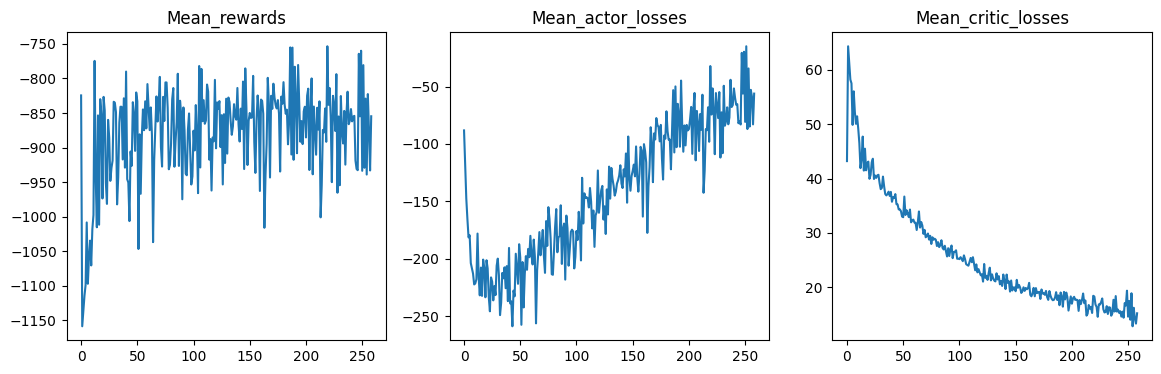

In [ ]:
all_rewards, mean_rewards, all_critic_losses, mean_critic_losses, all_actor_losses, mean_actor_losses = \
    [], [], [], [], [], []

for _ in range(int(1e5)):
    rewards, logits, state_vals, critic_losses = b_agent.play_game()
#     rewards = (np.array(rewards)*.1).tolist()
    all_critic_losses.append(torch.stack(critic_losses).mean().detach().numpy()) 
    
    all_rewards.append(np.median(np.array(rewards).sum(axis=0)))
    actor_loss = b_agent.calc_actor_loss(rewards, logits, state_vals)
    
    all_actor_losses.append(actor_loss.detach().numpy())
    b_agent.actor_opt.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(test_actor.parameters(), 60)
    b_agent.actor_opt.step()
    actor_lr_scheduler.step()
    
    ave_over=30
    if _%ave_over==0:
        mean_critic_losses.append(np.median(all_critic_losses[-ave_over:]))
        mean_actor_losses.append(np.median(all_actor_losses[-ave_over:]))
        mean_rewards.append(np.median(all_rewards[-ave_over:]))
        
        clear_output()
        fig, ax = plt.subplots(1, 3, figsize=(14,4))
        ax[0].plot(mean_rewards); ax[0].set_title('Mean_rewards')
        ax[1].plot(mean_actor_losses); ax[1].set_title('Mean_actor_losses')
        ax[2].plot(mean_critic_losses); ax[2].set_title('Mean_critic_losses')
        plt.show()

The model trains, but is extremely sensitive to learning rate (<=0.0006 for actor) and takes more steps to converge than before. Altough the sum rewards in the end might be higher. To stabilise trainning process we will work with the actor loss. 

- We will try to reduce bias by moving from MC estimation of Q-value to one step lookahead (further maybe to GAE).

- We will try to reduce variace by moving from making actor parameters update based on one trajectory to a batch of trajectories. 

In [ ]:
torch.cla

In [ ]:
6e-4